<a href="https://colab.research.google.com/github/jshin13/code_bucket/blob/main/LSTM_CNNarrhythmia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Lab 4 : Abnormal heartbeat detection with LSTMs and CNNs </h2>

Today, detecting abnormal heartbeat patterns is important in smartwatches.
In this lab, we will try to predict heart arrhythmia with LSTMs and 1-D CNNs.

We will use MIT-BIH Arrythmia dataset (https://www.physionet.org/content/mitdb/1.0.0/).
It consists of ECG recordings of several patients (patient IDs being 100, 101, etc.) with sampling frequency of 360 (samples/sec). Experts annotated/classified specific points in the signals as normal, abnormal, or non beat.

**NOTE1:** GPU is required for this lab.
You must change "Runtime type" to GPU from the "Runtime" tab ("Change Runtime type").

NOTE2: If you face RAM/memory overflow issue in this lab, ensure that you train only one model in single COLAB session. Feel free to implement your own memory optimization tricks too.

In [1]:
# load libraries (feel free to add more) and get dataset
import os
%pip install wfdb
import wfdb
import numpy as np
import pandas as pd
import urllib.request
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scipy.signal

from keras.layers import Bidirectional, LSTM
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D  # https://keras.io/api/layers/convolution_layers/convolution1d/
from keras.layers import LeakyReLU

from pywt import wavedec, dwt   # https://pywavelets.readthedocs.io/

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

if os.path.exists('./mba_dataset'): pass
else:
    urllib.request.urlretrieve('https://storage.googleapis.com/mitdb-1.0.0.physionet.org/mit-bih-arrhythmia-database-1.0.0.zip', './mba_dataset.zip')
    !unzip mba_dataset.zip -d mba_dataset
path_dataset='mba_dataset/mit-bih-arrhythmia-database-1.0.0/'

**Exploring the data**

Do `!ls mba_dataset/mit-bih-arrhythmia-database-1.0.0` to see the files present in dataset. We will primarily use \<patientID>.atr files. There are 48 patients with a 30 minutes of recording for each.
For '100' patient, let us check what all annotations are present in his/her signal. Run the code below.

In [2]:
!ls mba_dataset/mit-bih-arrhythmia-database-1.0.0
annotation = wfdb.rdann(os.path.join(path_dataset, '100'), 'atr')
print(annotation.symbol)  # symbols present in the data for patient 100

100.atr    106.dat  113.hea  119.hea  202.atr  209.xws	217.xws  230.atr
100.dat    106.hea  113.xws  119.xws  202.dat  210.atr	219.atr  230.dat
100.hea    106.xws  114.atr  121.atr  202.hea  210.dat	219.dat  230.hea
100.xws    107.atr  114.dat  121.dat  202.xws  210.hea	219.hea  230.xws
101.atr    107.dat  114.hea  121.hea  203.at_  210.xws	219.xws  231.atr
101.dat    107.hea  114.xws  121.xws  203.at-  212.atr	220.atr  231.dat
101.hea    107.xws  115.atr  122.atr  203.atr  212.dat	220.dat  231.hea
101.xws    108.at_  115.dat  122.dat  203.dat  212.hea	220.hea  231.xws
102-0.atr  108.atr  115.hea  122.hea  203.hea  212.xws	220.xws  232.atr
102.atr    108.dat  115.xws  122.xws  203.xws  213.atr	221.atr  232.dat
102.dat    108.hea  116.atr  123.atr  205.atr  213.dat	221.dat  232.hea
102.hea    108.xws  116.dat  123.dat  205.dat  213.hea	221.hea  232.xws
102.xws    109.atr  116.hea  123.hea  205.hea  213.xws	221.xws  233.atr
103.atr    109.dat  116.xws  123.xws  205.xws  214.at_	222.at_  

We can see a lot of 'N' symbols. It refers to "normal" heartbeat.
We provide below the list of symbols which we will consider as "abnormal" beats in this lab.
Any other symbol encountered in the dataset refer to "non-beat" and you **must** skip them in data preparation.
For detailed explanation about symbols, refer to https://archive.physionet.org/physiobank/annotations.shtml

In [3]:
# list of symbols for abnormal beats
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [4]:
# We provide function for loading an ECG file
def load_ECG_file(path):
    '''
    Input: path for patient files (excluding extension)
    Output: ECG signal, symbols (labels), indices for such symbols
    '''
    record = wfdb.rdrecord(path)
    annotation = wfdb.rdann(path, 'atr')
    signal = record.p_signal[:,0]    # ECG signal
    symbol = annotation.symbol  # symbols
    index = annotation.sample  # annotation index
    return signal, symbol, index
signal, symbol, index = load_ECG_file(os.path.join(path_dataset, '100'))  # check for yourself "signal" is ~30 min duration
print(f'Length of signal: {len(signal)}')  # ECG signal length (in terms of samples and NOT seconds); think why this corresponds to ~30 minutes of signal
print(f'Annotation symbols: {symbol}')  # annotation symbold
print(f'Annotation indices: {index}')  # annotion indices for patient 100 
print(f'Sample# {index[8]} has symbol marked as {symbol[8]} which refers to abnormal beat')  # sample 2044 is abnormal

Length of signal: 650000
Annotation symbols: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

Index contains the time in which we have a heart beat. In our case, we will use those indices as values obtained from a heartbeat detector for simplicity. For more information about heartbeat detection, you can visit https://archive.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm

**TASK 1 (10 points)**: Plot any random 10-second long portion of this ECG file. Then plot any 1-second portion which has an abnormality approximately in the middle of the signal.

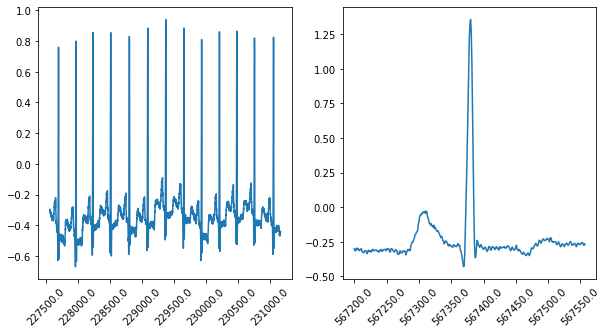

In [5]:
# CODE HERE
len(signal) / 360 / 60

FREQ = 360 #360 samples per sec

#360 samples per sec => 3600 per 10 secs
x = np.random.randint(0,len(signal)-FREQ*10,1)
x = np.arange(x,x+FREQ*10)

symidx = np.column_stack([symbol, index])
onesec_idx = int(np.random.choice(symidx[symidx[:,0] == 'A'][:,1]))
x1 = np.arange(onesec_idx-179, onesec_idx+179)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5*2,5))

ax1.plot(x, signal[x])
ax1.set_xticklabels(ax1.get_xticks(), rotation=45);

ax2.plot(x1, signal[x1])
ax2.set_xticklabels(ax2.get_xticks(), rotation=45);

**TASK 2 (20 points)**: (Data Preparation) Training data is usually represented by a matrix $X \in \mathbb{R}^{N\times D}$. N is the number of training points. D is the data dimension. We will consider one data point as +/- 3 seconds sequence of samples centered around a normal or abnormal symbol. Therefore, $D=6f$, where $f$ is the sampling frequency. Your goal is to construct such data matrix $X$. Your function should also output the corresponding label vector $y \in \mathbb{R}^{N\times 1}$. Labels should be 0 for Normal and 1 for abnormal. You should get close to a total of 100k data points. Do not forget to ignore non-beat symbols.

The patients for training set should be different from the ones in test set. Roughly divide the patients into 70:30 ratio or you may simply use the patient IDs already divided into train/test below.

In [6]:
# CODE HERE
# training patient IDs
pts_train = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210']

# testing patient IDs
pts_test = ['212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

def make_dataset():
    '''
    Output: X_train, y_train, X_test y_test
    '''
    X_train, y_train = [], []
    X_test, y_test = [], []
    t = FREQ*3 #3 seconds

    for id in tqdm(pts_train):
        signal, symbol, index = load_ECG_file(os.path.join(path_dataset, id))
        for i, idx in enumerate(index):
            idx0 = idx-t
            idx1 = idx+t

            if idx0 < 0 or idx1 > len(signal): pass
            else: 
                if symbol[i] == 'N':
                    X_train.append(signal[idx0:idx1])
                    y_train.append(0)
                elif symbol[i] in abnormal:
                    X_train.append(signal[idx0:idx1])
                    y_train.append(1)

    for id in tqdm(pts_test):
        signal, symbol, index = load_ECG_file(os.path.join(path_dataset, id))
        for i, idx in enumerate(index):
            idx0 = idx-t
            idx1 = idx+t

            if idx0 < 0 or idx1 > len(signal): pass
            else: 
                if symbol[i] == 'N':
                    X_test.append(signal[idx0:idx1])
                    y_test.append(0)
                elif symbol[i] in abnormal:
                    X_test.append(signal[idx0:idx1])
                    y_test.append(1)

    return X_train, y_train, X_test, y_test  

In [7]:
X_train, y_train, X_test, y_test = make_dataset()

In [8]:
np.array(X_train).shape, np.array(X_test).shape

((70187, 2160), (38912, 2160))

**TASK 3 (20 points)**: (Feature Extraction) You will use pywt wavelet library to extract features for training and testing data matrices. We will do "Multilevel 1D Discrete Wavelet Transform". Daubechies dB6 wavelet is used specifically. Number of level of decompositions (called levels) is chosen to be 4. It is a hyper-parameter which is determined based on nature of signal of interest. It is highly recommended to go through the following paper. It explains how Wavelet Transform is suited for signals localized in time and frequency:

'Güler, Inan, and Elif Derya Übeylı. "ECG beat classifier designed by combined neural network model." Pattern recognition 38.2 (2005): 199-208.'

Following is a hint on how you will extract features for a signal:

In [9]:
signal = np.random.random((10000,))
signal = scipy.signal.decimate(signal, 2)   # downsampling by 2 to reduce memory usage
features = wavedec(signal, 'db6', level=4)
print('Note that you get a list of features with shapes:', [_.shape for _ in features])

Note that you get a list of features with shapes: [(322,), (322,), (634,), (1258,), (2505,)]


The wavedec function calculates the discrete wavelet transform,

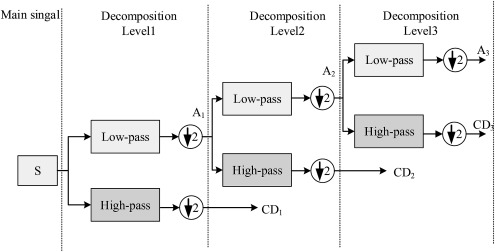

You have to do zero-padding on these features to make them equal length. Then, stack them along a new axis to finally obtain a 2D matrix ($S \times 5$) of features per signal.

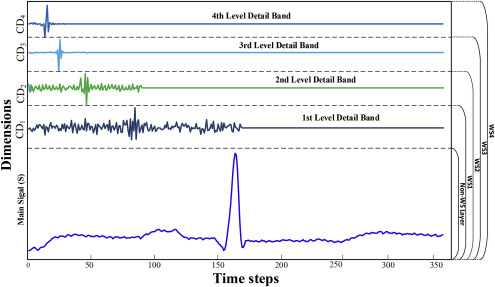

For more details, read the paper: [A novel wavelet sequence based on deep bidirectional LSTM network model for ECG signal classification](https://www.sciencedirect.com/science/article/pii/S0010482518300738?casa_token=qrJ6hAf9tkYAAAAA:7uXqrKY5WqUM6Mjc_qg7wJ4R6QA02BGFXP0o_pOKN09yB8JIXb7067JZWY88rZc8M1G6gkkA)

In [11]:
# CODE HERE
def extract_features(X):
    '''
    Input: X (N x D): Input data matrix
    Output: F (N x S x 5): Feature matrix
    '''
    X = scipy.signal.decimate(X, 2)   # downsampling by 2 to reduce memory usage
    N, M = np.array(X).shape
    results = []

    for j, dat in enumerate(tqdm(X)):
        features = wavedec(dat, 'db6', level=4, axis=0)
        # print(np.array(features).shape)
        for i, feat in enumerate(features):
            O = feat.shape[0]
            if O != M:
                features[i] = np.array(features[i].tolist() + [0 for i in range(M - O)])
            # features[i] = np.array(features[i].tolist() + [0 for i in range(N-len(feat))])

        features = np.array(features, dtype=float)
        # features = features.swapaxes(0,1)
        results.append(features)

    return np.array(results).swapaxes(1,2)

F_train = extract_features(X_train)
F_test = extract_features(X_test)
print(F_train.shape, F_test.shape)


(70187, 1080, 5) (38912, 1080, 5)


In [12]:
# import pickle

# if os.path.exists('feature.pickle'):
#     with open('feature.pickle', 'rb') as f:
#         F_train, F_test = pickle.load(f)
# else:

#     F_train = extract_features(X_train)
#     F_test = extract_features(X_test)

#     with open('feature.pickle', 'wb') as f:
#         pickle.dump([F_train, F_test], f)  

# print(F_train.shape, F_test.shape)      

**TASK 4 (20 points)**: Now, we are going to train a classifier to detect abnormal ECG cycles. We will train a simplified version of the LSTM-based network described in one of the [previously cited papers](https://www.sciencedirect.com/science/article/pii/S0010482518300738?casa_token=qrJ6hAf9tkYAAAAA:7uXqrKY5WqUM6Mjc_qg7wJ4R6QA02BGFXP0o_pOKN09yB8JIXb7067JZWY88rZc8M1G6gkkA). 
Using Keras, create a single layer Bidirectional LSTM model. Choose number of output units of LSTM equals to 32. Followed by LSTM layer, you should have a dense layer with sigmoid activation and number of output units equals to 1. The model should be trained for few epochs with optimizer as Adam, loss as BCE (Binary Cross Entropy), and the metric used should be accuracy. Report your accuracy on test set.

Hint on training command: `model.fit(F_train, y_train, batch_size = ..., epochs=..., verbose = 1)`


In [14]:
import tensorflow as tf

In [15]:
# CODE HERE
model = Sequential()
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

loss_fn = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
model.fit(F_train,np.array(y_train), batch_size=100, epochs=2, verbose=1)

Epoch 1/2
702/702 [==============================] - 77s 61ms/step - loss: 0.5896 - accuracy: 0.6967
Epoch 2/2
702/702 [==============================] - 43s 61ms/step - loss: 0.4170 - accuracy: 0.7997


In [17]:
# run this if you wish to print details on the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 64)                9728      
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
_________________________________________________________________


In [18]:
y_hat = model.predict(F_test)
y_hat_conv = np.array([1 if i > 0.5 else 0 for i in y_hat])

In [19]:
y_hat_conv.shape, np.array(y_test).shape

((38912,), (38912,))

In [20]:
accuracy_score(y_hat_conv, y_test)

0.744397615131579

You will find that this particular LSTM gives only 67-75% of test accuracy (depending on your implementation), which is close to random for our setup (due to data imbalance). We will move on to a superior model (for our setup) and code 1D CNNs. Note that performance of machine learning system depends on various factors like availability of data, choice of model, data processing, model size, etc.

**TASK 5 (20 points)**: (1-D CNNs) Different to LSTM model, we will have 1D CNN layer this time with 32 filters, kernel size of 5 and ReLU activation. You will add a flattening layer just after this (and before dense layer). CNN examples for Keras can easily be found online. Report test accuracy.

In [21]:
# CODE HERE
# Dense, Flatten, Dropout, Conv1D
model = Sequential()
model.add(Conv1D(32, (5), activation='relu')) #, input_shape=(F_train.shape)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(F_train,np.array(y_train), batch_size=100, epochs=5, verbose=1)

Epoch 1/5
702/702 [==============================] - 5s 4ms/step - loss: 0.2963 - accuracy: 0.8810
Epoch 2/5
702/702 [==============================] - 3s 4ms/step - loss: 0.0999 - accuracy: 0.9714
Epoch 3/5
702/702 [==============================] - 3s 4ms/step - loss: 0.0706 - accuracy: 0.9808
Epoch 4/5
702/702 [==============================] - 3s 4ms/step - loss: 0.0576 - accuracy: 0.9836
Epoch 5/5
702/702 [==============================] - 3s 4ms/step - loss: 0.0503 - accuracy: 0.9857


In [23]:
y_hat = model.predict(F_test)
y_hat_conv = np.array([1 if i > 0.5 else 0 for i in y_hat])

In [24]:
y_hat_conv.shape, np.array(y_test).shape

((38912,), (38912,))

In [25]:
accuracy_score(y_hat_conv, y_test)

0.8211091694078947

**TASK 6 (10 points)**: (Deep CNNs) Repeat the previous task by replacing the single convolutional layer with two of them, thereby making the model deeper. Comment on what differences you observe w.r.t. Task 5.

In [11]:
# CODE HERE
model = Sequential()
model.add(Conv1D(32, (5), activation='relu'))
model.add(Conv1D(16, (5), activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(F_train,np.array(y_train), batch_size=100, epochs=5, verbose=1)

Epoch 1/5
702/702 [==============================] - 36s 6ms/step - loss: 0.2878 - accuracy: 0.8835
Epoch 2/5
702/702 [==============================] - 4s 6ms/step - loss: 0.0867 - accuracy: 0.9760
Epoch 3/5
702/702 [==============================] - 4s 6ms/step - loss: 0.0647 - accuracy: 0.9821
Epoch 4/5
702/702 [==============================] - 4s 6ms/step - loss: 0.0514 - accuracy: 0.9861
Epoch 5/5
702/702 [==============================] - 4s 6ms/step - loss: 0.0446 - accuracy: 0.9868


In [13]:
y_hat = model.predict(F_test)
y_hat_conv = np.array([1 if i > 0.5 else 0 for i in y_hat])

In [14]:
y_hat_conv.shape, np.array(y_test).shape

((38912,), (38912,))

In [15]:
accuracy_score(y_hat_conv, y_test)

0.8343441611842105

With CNNs, your training accuracy should be above 95% and testing accuracy should be above 80%.

## Discussion
Increase in the depth of network resulted in increased complexity of the network allowing for improvement in both training and testset accuracy. 

**TASK 7 (BONUS) (+20 points)**:


Propose another network architecture using Keras to classify between normal and abnormal (You can use papers like this to find inspiration: https://www.sciencedirect.com/science/article/pii/S0010482518300738?casa_token=qrJ6hAf9tkYAAAAA:7uXqrKY5WqUM6Mjc_qg7wJ4R6QA02BGFXP0o_pOKN09yB8JIXb7067JZWY88rZc8M1G6gkkA)
State the reasoning behind your choice and report accuracy on test set.

OR

Use CNN to classify between the different classes indicated in abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S'].
Report balanced accuracy score on the test set: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html


**You are ready to submit in Blackboard!**

Please suffix your colab file with `_<jhID>`
For	eg: Lab4_LSTM_CNNarrhythmia_myjhID12

In [12]:
lrelu = LeakyReLU()

In [13]:
from keras.layers import MaxPooling1D

In [19]:
# CODE HERE
model = Sequential()
model.add(Conv1D(32, (3), activation=lrelu))
model.add(MaxPooling1D())
model.add(Conv1D(16, (3), activation=lrelu))
model.add(MaxPooling1D())
model.add(Conv1D(8, (3), activation=lrelu))
model.add(MaxPooling1D())
model.add(Conv1D(4, (3), activation=lrelu))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
model.fit(F_train,np.array(y_train), batch_size=100, epochs=5, verbose=1)

Epoch 1/5
702/702 [==============================] - 6s 7ms/step - loss: 0.4179 - accuracy: 0.8046
Epoch 2/5
702/702 [==============================] - 4s 6ms/step - loss: 0.1068 - accuracy: 0.9685
Epoch 3/5
702/702 [==============================] - 4s 6ms/step - loss: 0.0724 - accuracy: 0.9777
Epoch 4/5
702/702 [==============================] - 4s 6ms/step - loss: 0.0604 - accuracy: 0.9824
Epoch 5/5
702/702 [==============================] - 4s 6ms/step - loss: 0.0526 - accuracy: 0.9845


In [21]:
y_hat = model.predict(F_test)
y_hat_conv = np.array([1 if i > 0.5 else 0 for i in y_hat])

In [22]:
y_hat_conv.shape, np.array(y_test).shape

((38912,), (38912,))

In [23]:
accuracy_score(y_hat_conv, y_test)

0.844495271381579

## Discussion
First, the depth of layers was increased to advance the complexity of network. The filter size of the convolutional layers was reduced to increase the resolution of the features being learned by the network. The 1D maxpooling layers were added to address the overfitting issue. Lastly, leaky relu is used only as an experimental purpose, but it is expected that this would not contribute much improvement in performance as the output of the sigmoid does not include negative values